# IMV

### Title: IMV AI Timetable - Online (Part 1)

<br>Objective:&nbsp;&nbsp;&nbsp;&nbsp;Enhance IMV AI online calendar which includes ADCode and login URL.
<br>Input:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;IMV AI Timetable (pdf).
<br>Output:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;IMV AI Online Timetable (html).
<br>URL:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://eatbreathedatascience.blogspot.com/2021/04/day-date-time-venue-remarks-adcode.html
<br>
<br>Note:
<br><br>1. What's the purpose of the exercise ?  Through this excercise, we will learn the problems in using **semi-structured data** and explore inventive ways to overcome these problems.
<br><br>2. What's the benefit from using the online calendar ? By saving the link on the phone and using browsers that support invoking Singpass, **we can click on the link and sign-in _without having to scan the QRCode_**.
<br><br>3. The codes below we "just working codes".   Not considered good coding, optimised or 'pythonic'.  Certain codes are obsolete.  Just working.
<br><br>4. Excel also supports importing of PDF.  You can compare the efforts required to deliver the same output.

### Title: IMV AI Timetable - Google Calendar (Part 2)

<br>Objective:&nbsp;&nbsp;&nbsp;&nbsp;New Features: Accessing the IMV calendar on Google Phone with Notification to clock time.
<br>Input:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Part 1 Output.
<br>Output:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\*.ics iCalendar file to import into Google Calendar.
<br>
<br>Note:
<br><br>1. What's the purpose of the exercise ?  With the Google Calendar available on the personal mobile phone, it will trigger an notification when the class starts.
<br><br>2. What's the benefit from using the Google calendar ? This will ensure that we will not forget to clock in our time for the class.  In addition, we can click on the notification, follow the steps and complete the clock time process.

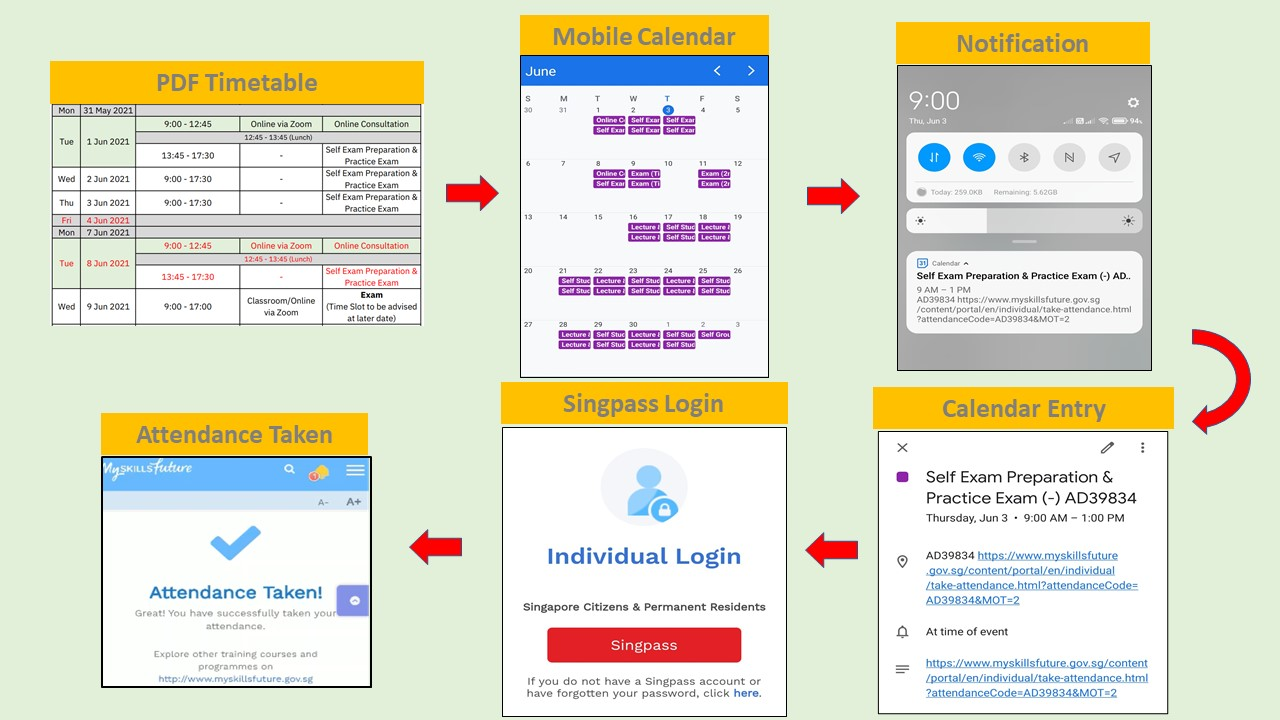

In [1]:
from tabula import read_pdf
from tabulate import tabulate
import json
import pandas as pd
import re
import numpy as np
from copy import deepcopy

pattern = '^\d{1,2}:\d{2}-\d{2}:\d{2}$'
col = ['Day','Date','Time','Venue','Remarks','ADCode']
df = pd.DataFrame([],columns=col)

page=dict()
dayofweek = set(['Mon','Tue','Wed','Thu','Fri'])
date = set(['Feb','Mar','Apr','May','Jun','Jul','Aug'])
venue = set(['Team-Arranged','Online via Zoom'])
remarks = set(['Project Discussion','Midpoint Project Discussion','Lecture & Tutorial/Lab', \
          'Self Study & Self Directed E-Learning','Self Group Project Discussion', \
          'Self Exam Preparation & Practice Exam','Exam (Time Slot to be advised at later date)', \
          'Exam (Time Slot to be advised at later date)', 'Exam (2nd Chance) (Time Slot to be advised at later date)', \
          'Online Consultation','Final Project Presentation'])

filepath = 'Data\\'

<br>

**For cells like these where the phrase is split into several lines, there is a line break character which needs to be removed**
<br>
<br>
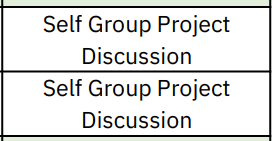

In [2]:
file = filepath + "IBM IMVAI-0801 Schedule V1.pdf"

pdf = read_pdf(file, 
               pages='all',output_format='json')

for page in range(5,11):    # replace single quote with double quote & remove line breaks
    jstr = str(pdf[page]).replace('\'','\"').replace('\\r',' ')
    js = json.loads(jstr)

    for p1,p2 in enumerate(js['data']):
        if 'Module Name' in str(p2):
            continue
        dft = dict()
        for l1,l2 in enumerate(p2):
            txt = l2['text']
            txttmp = txt.split()
            if not txt.strip():
                continue
            elif txt in str(dayofweek):
                dft['Day'] = txt
            elif re.search(pattern, txt.replace(' ','')):
                dft['Time'] = txt
            elif txt in venue:
                dft['Venue'] = txt
            elif txt in remarks:
                dft['Remarks'] = txt
            elif len(txttmp) > 1:
                if txttmp[1] in date and not txt in ['1 May Labour Day','13 May Hari Raya Puasa']:
                    dft['Date'] = txt
        if dft:
           df = df.append(dft,ignore_index=True)
        
df.reset_index(drop=True,inplace=True) 

<br>**These time slots don't have Day & Date because of the alignment.
The codes below will fill in the Day & Date.**
<br><br>
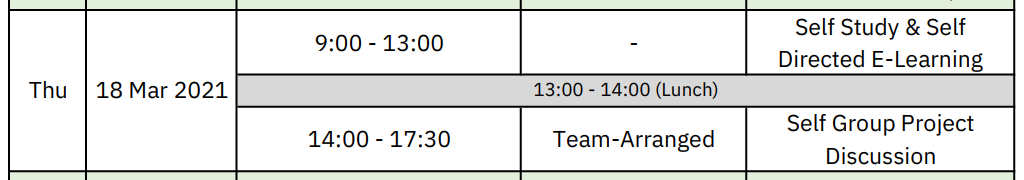

In [3]:
for i in range(len(df)):   # should use iterrows
    if pd.isna(df.loc[i,'Day']) and pd.isna(df.loc[i,'Date']):
        if int(df.loc[i,'Time'][0]) > 5:      # morning lessons
            df.loc[i,'Day'] = df.loc[i+1,'Day']
            df.loc[i,'Date'] = df.loc[i+1,'Date']
        else:    # int(df.loc[i,'Time'][0]) <=5:
            df.loc[i,'Day'] = df.loc[i-1,'Day']
            df.loc[i,'Date'] = df.loc[i-1,'Date']
        
df.dropna(subset=['Remarks'],inplace=True)
df.reset_index(drop=True,inplace=True)  

<br>**The middle row is not aligned to the Day & Date.  Is not able to parse the PDF correctly.  Needs manual repair.**
<br><br>
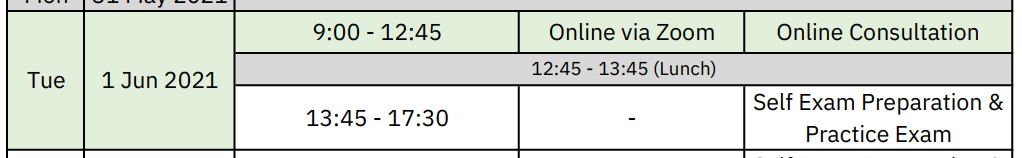

In [4]:
daterepair = {'28 May 2021':['Tue','1 Jun 2021'],
              '3 Jun 2021':['Tue','8 Jun 2021'],
              '23 Jul 2021':['Tue','27 Jul 2021'],
              '30 Jul 2021':['Mon','2 Aug 2021']}

df.reset_index(drop=True,inplace=True) 
dfdr = df[pd.isna(df['Day'])].index
for i in dfdr.tolist()[0::2]:
    df.iloc[i]['Day']  = daterepair[df.iloc[i-1]['Date']][0]
    df.iloc[i]['Date'] = daterepair[df.iloc[i-1]['Date']][1]
    df.iloc[i+1]['Day']  = daterepair[df.iloc[i-1]['Date']][0]
    df.iloc[i+1]['Date'] = daterepair[df.iloc[i-1]['Date']][1]

Specify the first ADCode and propagate to the remaining days. <br> **Adjustments can be easily done by update this dictionary ADCode.  eg. On the Exam's day, we didn't signin.**</br>

In [5]:
# ADCode = {'23 Apr 2021':'39809', '30 Apr 2021':'39800'}  # testing adjustments
ADCode = {'23 Apr 2021':'39809', '11 Jun 2021':'39837'}
    
for i,r in df.iterrows():
    if not ADCode.get(r['Date'], '') == '':
        r['ADCode'] = ADCode[r['Date']]
        ADCode.pop(r['Date'],None)
    elif i > 0 and pr['ADCode']:
        if r['Venue']=='Online via Zoom' and pr['Venue']=='Online via Zoom' and \
            r['Date']== pr['Date'] and not pd.isna(pr['ADCode']):
            r['ADCode'] = int(pr['ADCode'])+1
        elif not pd.isna(pr['ADCode']):
            r['ADCode'] = int(pr['ADCode'])+1
    pr = r

Prepending the 'AD' to the ADCode and forming the URL.

In [6]:
df['ADCode'] = df['ADCode'].apply(lambda x: 'AD' + str(x) if not pd.isna(x) else np.NaN)
df['ADCode-link'] = \
    'https://www.myskillsfuture.gov.sg/content/portal/en/individual/take-attendance.html?attendanceCode=' \
    + df['ADCode'] + '&MOT=2'

Replacing all NAN with '-' for nicer display.  Removing the year 2021 from the date to reduce the column width.

In [7]:
df = df.applymap(lambda x: x if not pd.isna(x) else '-')
df['Date'] = df['Date'].apply(lambda x: f'{x.split()[0]} {x.split()[1]}')

Save the csv

In [8]:
file = filepath + 'imv-ADCode.csv'

df.to_csv(file,index=False)

Save the html

In [9]:
file = filepath + 'imv-ADCode.html'

pd.set_option('display.max_colwidth', 500)
colsp = [30,50,90,120,130,70,500]

df.to_html(file,index=False,\
           render_links=True,col_space=colsp,justify='justify-all')

### You can access the IMV AI Online Calendar at 

#### https://eatbreathedatascience.blogspot.com/2021/04/day-date-time-venue-remarks-adcode.html 

In [10]:
pd.set_option('display.max_rows',200)
df.head(9)

,Day,Date,Time,Venue,Remarks,ADCode,ADCode-link
0,Mon,19 Apr,9:00 - 12:30,Online via Zoom,Lecture & Tutorial/Lab,-,-
1,Mon,19 Apr,13:30 - 17:30,Online via Zoom,Lecture & Tutorial/Lab,-,-
2,Tue,20 Apr,9:00 - 15:00,-,Self Study & Self Directed E-Learning,-,-
3,Wed,21 Apr,9:00 - 12:30,Online via Zoom,Lecture & Tutorial/Lab,-,-
4,Wed,21 Apr,13:30 - 17:30,Online via Zoom,Lecture & Tutorial/Lab,-,-
5,Thu,22 Apr,9:00 - 17:30,-,Self Study & Self Directed E-Learning,-,-
6,Fri,23 Apr,9:00 - 12:30,Online via Zoom,Lecture & Tutorial/Lab,AD39809,https://www.myskillsfuture.gov.sg/content/portal/en/individual/take-attendance.html?attendanceCode=AD39809&MOT=2
7,Fri,23 Apr,13:30 - 17:30,Online via Zoom,Lecture & Tutorial/Lab,AD39810,https://www.myskillsfuture.gov.sg/content/portal/en/individual/take-attendance.html?attendanceCode=AD39810&MOT=2
8,Mon,26 Apr,9:00 - 17:30,-,Self Study & Self Directed E-Learning,AD39811,https://www.myskillsfuture.gov.sg/content/portal/en/individual/take-attendance.html?attendanceCode=AD39811&MOT=2


In [19]:
from icalendar import Calendar, Event, Alarm

month = {'Apr':'04', 'May': '05', 'Jun':'06', 'Jul':'07', 'Aug':'08'}
fulldaycond = ['090000','173000']
splittime = '130000'

cal = Calendar()

def crtevt(date, time, venue, remarks, ADCode, ADCodelink):

    startdate = '2021' + month.get(date[-3:]) + date[0:len(date)-4].rjust(2,'0')  
    starttime = time.split('-')[0].strip().replace(':','').rjust(4,'0') + '00'
    enddate = startdate
    endtime = time.split('-')[1].strip().replace(':','').rjust(4,'0') + '00'

    evt = []
    alarm = []
    
    if not (int(starttime[0:2]) <= 11 and int(endtime[0:2]) > 14):

        evtno = 0
        evt.append(Event())
        alarm.append(Alarm())

        starttime = time.split('-')[0].strip().replace(':','').rjust(4,'0') + '00'
        startdatetime = startdate + 'T' + starttime
        endtime = time.split('-')[1].strip().replace(':','').rjust(4,'0') + '00'
        enddatetime = enddate + 'T' + endtime

        evt[evtno]['dtstart'] = startdatetime
        evt[evtno]['summary'] = remarks + ' (' + venue + ') ' + ADCode
        evt[evtno]['dtend'] = enddatetime
        evt[evtno]['LOCATION'] = ADCode + ' ' + ADCodelink
        evt[evtno]['DESCRIPTION'] = ADCodelink
        alarm[evtno]['ACTION'] = 'DISPLAY'
        alarm[evtno]['DESCRIPTION'] = 'This is an event reminder'
        alarm[evtno]['TRIGGER'] = '-P0DT0H00M0S'

        evt[evtno].add_component(alarm[evtno])
        
    else:

        evtno = 0
        evt.append(Event())
        alarm.append(Alarm())

        starttime = time.split('-')[0].strip().replace(':','').rjust(4,'0') + '00'
        startdatetime = startdate + 'T' + starttime
        endtime = splittime
        enddatetime = enddate + 'T' + endtime

        evt[evtno]['dtstart'] = startdatetime
        evt[evtno]['summary'] = remarks + ' (' + venue + ') ' + ADCode
        evt[evtno]['dtend'] = enddatetime
        evt[evtno]['LOCATION'] = ADCode + ' ' + ADCodelink
        evt[evtno]['DESCRIPTION'] = ADCodelink
        alarm[evtno]['ACTION'] = 'DISPLAY'
        alarm[evtno]['DESCRIPTION'] = 'This is an event reminder'
        alarm[evtno]['TRIGGER'] = '-P0DT0H00M0S'

        evt[evtno].add_component(alarm[evtno])
        
        evtno = 1
        evt.append(Event())
        alarm.append(Alarm())

        starttime = splittime
        startdatetime = startdate + 'T' + starttime
        endtime = time.split('-')[1].strip().replace(':','').rjust(4,'0') + '00'
        enddatetime = enddate + 'T' + endtime

        evt[evtno]['dtstart'] = startdatetime
        evt[evtno]['summary'] = remarks + ' (' + venue + ') ' + ADCode
        evt[evtno]['dtend'] = enddatetime
        evt[evtno]['LOCATION'] = ADCode + ' ' + ADCodelink
        evt[evtno]['DESCRIPTION'] = ADCodelink
        alarm[evtno]['ACTION'] = 'DISPLAY'
        alarm[evtno]['DESCRIPTION'] = 'This is an event reminder'
        alarm[evtno]['TRIGGER'] = '-P0DT0H00M0S'

        evt[evtno].add_component(alarm[evtno])

    return evt

    
    return evt

# i = 0

for i, row in df.iterrows():
    if i > 35:
        i += 1
        evt = crtevt(row['Date'],row['Time'],row['Venue'],row['Remarks'],row['ADCode'],row['ADCode-link'])
        for j in evt:
            cal.add_component(j)

In [20]:
file = filepath + 'imv-ADCode.ics'

f = open(file, 'wb')
f.write(cal.to_ical())
f.close()